In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import(Dense,
                                    BatchNormalization,
                                    LeakyReLU,
                                    Reshape,
                                    Conv2DTranspose,
                                    Conv2D,
                                    Dropout,
                                    Flatten)
import matplotlib.pyplot as plt

# Load and Process the MNIST Dataset
For this tutorial, we can use the MNIST dataset. The MNIST dataset contains 60,000 training images and 10,000 testing images taken from American Census Bureau employees and American high school students 

In [ ]:
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

# train_images = train_images.reshape(-1, 3072)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_images.shape

(50000, 3072)

# Build the Model
As mentioned above, every GAN must have at least one generator and one discriminator. Since we are dealing with image data, we need to benefit from Convolution and Transposed Convolution (Inverse Convolution) layers in these networks. Let's define our generator and discriminator networks below.

# Generator Network
Our generator network is responsible for generating 28x28 pixels grayscale fake images from random noise. Therefore, it needs to accept 1-dimensional arrays and output 28x28 pixels images. For this task, we need Transposed Convolution layers after reshaping our 1-dimensional array to a 2-dimensional array. Transposed Convolution layers can increase the size of a smaller array. We also take advantage of BatchNormalization and LeakyReLU layers. The below lines create a function which would generate a generator network with Keras Sequential API:

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
print(generator)

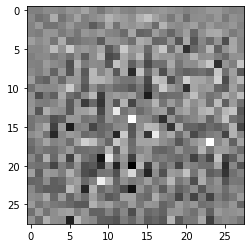

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Discriminator Network
For our discriminator network, we need to follow the inverse version of our generator network. It takes the 28x28 pixels image data and outputs a single value, representing the possibility of authenticity. So, our discriminator can review whether a sample image generated by the generator is fake.
We follow the same method that we used to create a generator network, The following lines create a function that would create a discriminator model using Keras Sequential API

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00339384]], shape=(1, 1), dtype=float32)


# Configure the Model
Since we are training two sub-networks inside a GAN network, we need to define two loss functions and two optimizers.
Loss Functions: We start by creating a Binary Crossentropy object from tf.keras.losses module. We also set the from_logits parameter to True. After creating the object, we fill them with custom discriminator and generator loss functions. Our discriminator loss is calculated as a combination of (i) the discriminator’s predictions on real images to an array of ones and (ii) its predictions on generated images to an array of zeros. Our generator loss is calculated by measuring how well it was able to trick the discriminator. Therefore, we need to compare the discriminator’s decisions on the generated images to an array of 1s.

# Optimizers: 
We also set two optimizers separately for generator and discriminator networks. We can use the Adam optimizer object from tf.keras.optimizers module.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Set the Checkpoints
We would like to have access to previous training steps and TensorFlow has an option for this: checkpoints. By setting a checkpoint directory, we can save our progress at every epoch. This will be especially useful when we restore our model from the last epoch. The following lines configure the training checkpoints by using the os library to set a path to save all the training steps

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train the Model
Now our data ready, our model is created and configured. It is time to design our training loop. Note that at the moment, GANs require custom training loops and steps. I will try to make them as understandable as possible for you. Make sure that you read the code comments in the Github Gists.
Let’s create some of the variables with the following lines:

In [ ]:
EPOCHS = 80
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Define the Training Step
This is the most unusual part of our tutorial: We are setting a custom training step. After defining the custom train_step() function by annotating the tf.function module, our model will be trained based on the custom train_step() function we defined.
The code below with excessive comments are for the training step. Please read the comments carefully:

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Now that we created our custom training step with tf.function annotation, we can define our train function for the training loop.
# Define the Training Loop
We define a function, named train, for our training loop. Not only we run a for loop to iterate our custom training step over the MNIST, but also do the following with a single function:
During the Training:
* Start recording time spent at the beginning of 
each epoch;
* Produce GIF images and display them,
* Save the model every five epochs as a checkpoint,
* Print out the completed epoch time; and
* Generate a final image in the end after the training is completed.

The following lines with detailed comments, do all these tasks:

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):    
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Image Generation Function
In the train function, there is a custom image generation function that we haven’t defined yet. Our image generation function does the following tasks:
* Generate images by using the model;
* Display the generated images in a 4x4 grid layout using matplotlib;
* Save the final figure in the end

The following lines are in charge of these tasks:

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Start the Training
After training three complex functions, starting the training is fairly easy. Just call the train function with the below arguments:

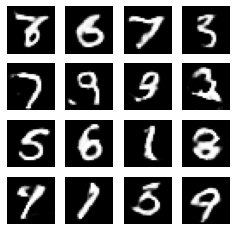

In [ ]:
train(train_dataset, EPOCHS)

# Generate Digits
Before generating new images, let's make sure we restore the values from the latest checkpoint with the following line:

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

We can also view the evolution of our generative GAN model by viewing the generated 4x4 grid with 16 sample digits for any epoch with the following code:

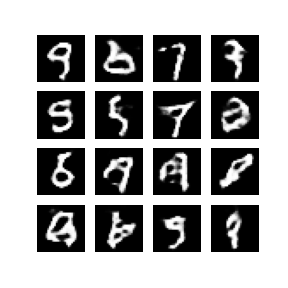

In [ ]:
# PIL is a library which may open different image file formats
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(43)

or better yet, let's create a GIF image visualizing the evolution of the samples generated by our GAN with the following code:

In [ ]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)
display.Image(open('dcgan.gif','rb').read())